In [8]:
from torchvision import transforms

transform  = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [9]:
from torchvision import models, datasets, transforms
from torchvision.models import ResNet50_Weights
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm   # For progress bar
from PIL import ImageFile

# allow partially read images instead of failing
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Define transforms and device
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# Prepare Model (remove final layer for features)
resnet = models.resnet50(weights=ResNet50_Weights.DEFAULT)
model = nn.Sequential(*(list(resnet.children())[:-1]))  # outputs [batch, 2048, 1, 1]
model.eval()
model.to(device)

def extract_features(batch_images):
    with torch.no_grad():
        batch_images = batch_images.to(device)
        feats = model(batch_images)                 # [batch, 2048, 1, 1]
        feats = feats.reshape(feats.size(0), -1)    # [batch, 2048]
        return feats.cpu().numpy()

dataset = datasets.ImageFolder("data/roads", transform=transform)
loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

train_features = []
train_labels = []

for imgs, labels in tqdm(loader, desc="Extracting features"):
    batch_feats = extract_features(imgs)
    train_features.append(batch_feats)
    train_labels.append(labels.numpy())

train_features = np.concatenate(train_features, axis=0)
train_labels = np.concatenate(train_labels, axis=0)

print("Feature vectors shape:", train_features.shape)
print("Labels shape:", train_labels.shape)

Using device: cuda


Extracting features: 100%|██████████| 146/146 [00:03<00:00, 39.88it/s]

Feature vectors shape: (4656, 2048)
Labels shape: (4656,)


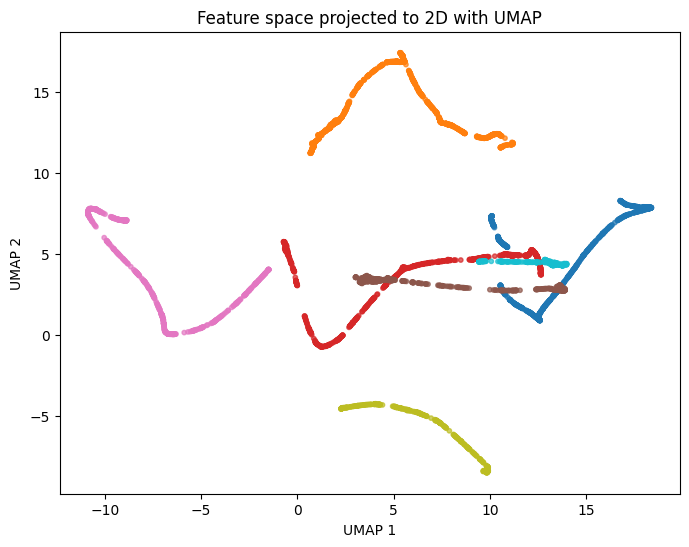

In [10]:
import matplotlib.pyplot as plt
import umap



reducer = umap.UMAP(n_components=6)
features_2D_UMAP = reducer.fit_transform(train_features)


plt.figure(figsize=(8,6))
plt.scatter(features_2D_UMAP[:,0], features_2D_UMAP[:,1], c=train_labels, cmap='tab10', s=10, alpha=0.7)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.title("Feature space projected to 2D with UMAP")
plt.show()

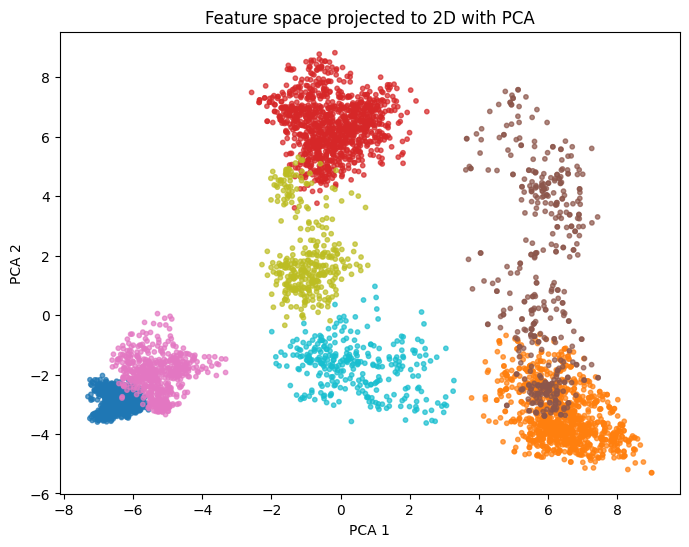

In [11]:
import sklearn.decomposition
from sklearn.decomposition import PCA


reducer = PCA(n_components=6)
features_2D_PCA = reducer.fit_transform(train_features)


plt.figure(figsize=(8,6))
plt.scatter(features_2D_PCA[:,0], features_2D_PCA[:,1], c=train_labels, cmap='tab10', s=10, alpha=0.7)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Feature space projected to 2D with PCA")
plt.show()



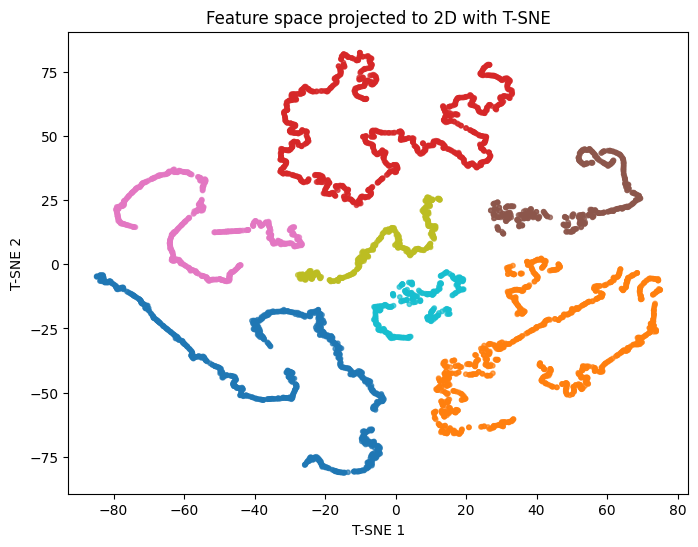

In [12]:
from sklearn.manifold import TSNE


reducer = TSNE(n_components=2, random_state=67)
features_2D_TSNE = reducer.fit_transform(train_features)


plt.figure(figsize=(8,6))
plt.scatter(features_2D_TSNE[:,0], features_2D_TSNE[:,1], c=train_labels, cmap='tab10', s=10, alpha=0.7)
plt.xlabel("T-SNE 1")
plt.ylabel("T-SNE 2")
plt.title("Feature space projected to 2D with T-SNE")
plt.show()

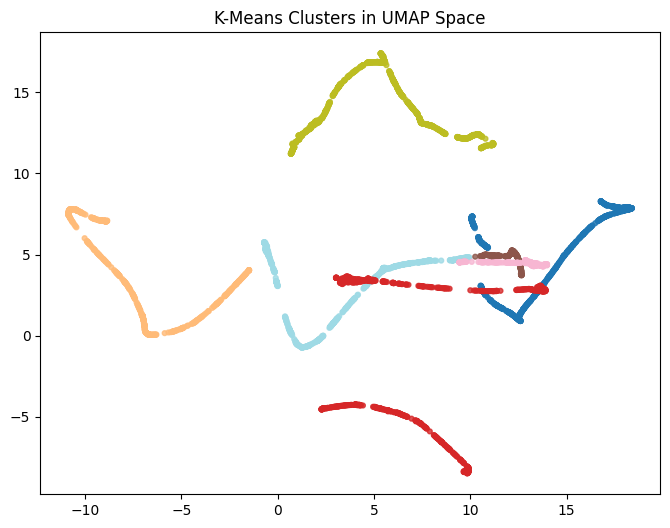

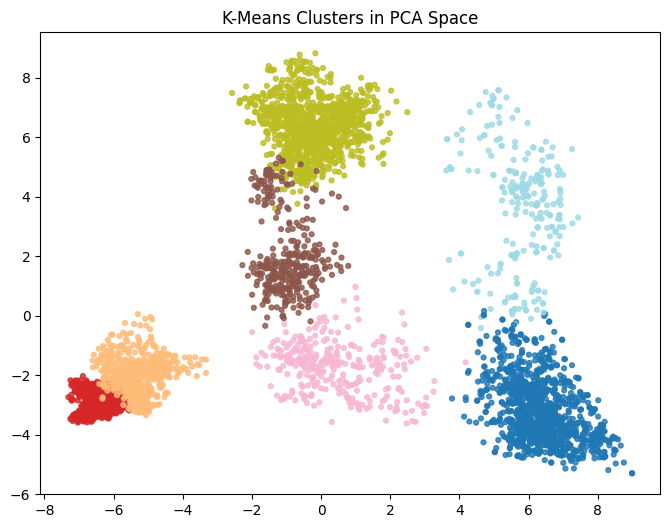

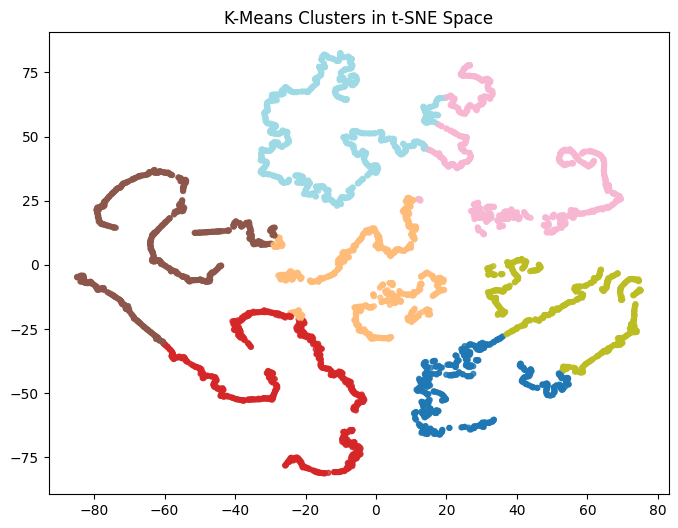

In [13]:
from sklearn.cluster import KMeans


#umap


n_clusters = len(np.unique(train_labels))  # or choose the “true” number or experiment with k
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(features_2D_UMAP)  # features_2D from UMAP/PCA/t-SNE

# Visualize clusters
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.scatter(features_2D_UMAP[:,0], features_2D_UMAP[:,1], c=cluster_labels, cmap='tab20', s=12, alpha=0.8)
plt.title('K-Means Clusters in UMAP Space')
plt.show()



# pca

n_clusters = len(np.unique(train_labels))  # or choose the “true” number or experiment with k
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(features_2D_PCA)  # features_2D from UMAP/PCA/t-SNE

# Visualize clusters
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.scatter(features_2D_PCA[:,0], features_2D_PCA[:,1], c=cluster_labels, cmap='tab20', s=12, alpha=0.8)
plt.title('K-Means Clusters in PCA Space')
plt.show()



# t-sne


n_clusters = len(np.unique(train_labels))  # or choose the “true” number or experiment with k
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(features_2D_TSNE)  # features_2D from UMAP/PCA/t-SNE

# Visualize clusters
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.scatter(features_2D_TSNE[:,0], features_2D_TSNE[:,1], c=cluster_labels, cmap='tab20', s=12, alpha=0.8)
plt.title('K-Means Clusters in t-SNE Space')
plt.show()









In [14]:
# get scores for each model



from sklearn.metrics import davies_bouldin_score, silhouette_score

db_score = davies_bouldin_score(features_2D_UMAP, cluster_labels)
sil_score = silhouette_score(features_2D_UMAP, cluster_labels)

print("UMAP Davies-Bouldin Index:", db_score)
print("UMAP Silhouette Score:", sil_score)


db_score = davies_bouldin_score(features_2D_PCA, cluster_labels)
sil_score = silhouette_score(features_2D_PCA, cluster_labels)

print("PCA Davies-Bouldin Index:", db_score)
print("PCA Silhouette Score:", sil_score)


db_score = davies_bouldin_score(features_2D_TSNE, cluster_labels)
sil_score = silhouette_score(features_2D_TSNE, cluster_labels)

print("TSNE Davies-Bouldin Index:", db_score)
print("TSNE Silhouette Score:", sil_score)




UMAP Davies-Bouldin Index: 1.720258694114451
UMAP Silhouette Score: 0.26561111211776733
PCA Davies-Bouldin Index: 1.172756259555973
PCA Silhouette Score: 0.3593478798866272
TSNE Davies-Bouldin Index: 0.7989065868928146
TSNE Silhouette Score: 0.39433249831199646
